# 0. Load data and take a look
* Inspect the variables
* Check missing value
* Simple visulization

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

news = pd.read_csv('Eluvio_DS_Challenge.csv')

In [156]:
#having a look at the head of the dataset
news.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [157]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null int64
date_created    509236 non-null object
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
category        509236 non-null object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [158]:
print(news['down_votes'].value_counts())
print(news['over_18'].value_counts())
print(news['author'].value_counts())
print(news['category'].value_counts())

0    509236
Name: down_votes, dtype: int64
False    508916
True        320
Name: over_18, dtype: int64
davidreiss666      8897
anutensil          5730
DoremusJessup      5037
maxwellhill        4023
igeldard           4013
                   ... 
topiks1               1
highrockstudios       1
enevo                 1
anarchistbanker       1
gahte3                1
Name: author, Length: 85838, dtype: int64
worldnews    509236
Name: category, dtype: int64


In [159]:
# Dropping category and down_votes as they have same values.
news.drop(columns=["down_votes","category"], axis = 1, inplace = True)

In [161]:
news['time_created'] = pd.to_datetime(news['time_created'], unit='s')
news['date_created'] = pd.to_datetime(news['date_created'])
news['day'] = news['date_created'].dt.day_name()
news['year'] = news['date_created'].dt.year
news['month'] = news['date_created'].dt.month

Text(0.5, 1.0, 'Num of posts vs Day of Week')

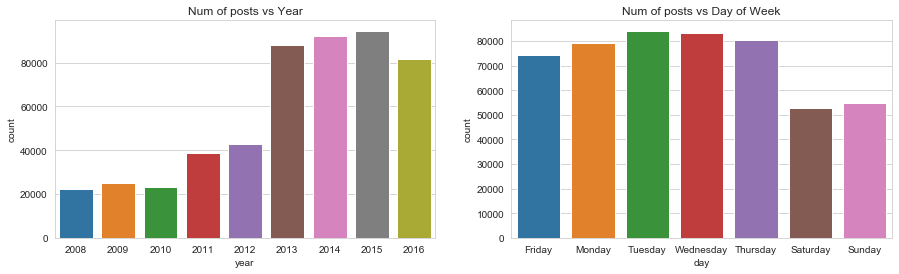

In [162]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=sns.countplot(x='year',data=news,ax=ax[0])
g.set_title('Num of news vs Year')
g=sns.countplot(x='day',data=news,ax=ax[1])
g.set_title('Num of news vs Day of Week')

Text(0.5, 1.0, 'Average up_votes vs Day of Week')

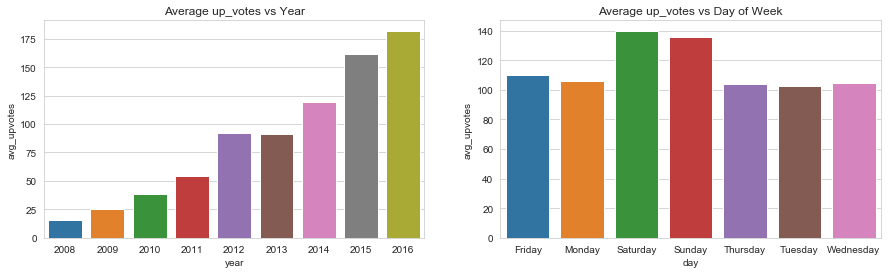

In [177]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
set1 = news.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
g = sns.barplot(x='year',y='avg_upvotes',data=set1, ax=ax[0])
g.set_title('Average up_votes vs Year')
set2 = news.groupby('day').mean()['up_votes'].reset_index(name='avg_upvotes')
g = sns.barplot(x='day',y='avg_upvotes',data=set2, ax=ax[1])
g.set_title("Average up_votes vs Day of Week")

## 1. Text Preprocess

* Remove punctuations
* Tokenization 
* Lemmatization and Stemmming

In [164]:
# Load the regular expression library
import re

def clean_document(document):
    """Cleans document by removing unnecessary punctuation. It also removes
    any extra periods and merges acronyms to prevent the tokenizer from
    splitting a false sentence
    """
    document = re.sub('[^A-Za-z0-9 \']', '', document)
    document = re.sub("\'s", "", document)
    document = document.replace("New York Times", "NewYorkTimes")
    document = document.replace('U of', 'University of')
    document = document.replace('U S', 'US').replace('U N', 'UN')
    
    # Remove extra whitespace
    document = ' '.join(document.split())
    return document

In [165]:
# Since the goal of this analysis is to perform topic modeling, 
# we will solely focus on the title data from each news, and/ drop other metadata columns.
docs = [clean_document(doc) for doc in news['title']]

In [171]:
# Tokenize the documents.
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove stop words.
docs = [[token for token in doc if not token in STOPWORDS] for doc in docs]

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1 ] for doc in docs]

In [175]:
import nltk
# nltk.download('wordnet') 

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [176]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

docs = [[stemmer.stem(lemmatizer.lemmatize(token)) for token in doc] for doc in docs]

In [ ]:
# Top 10 most common works
word_counts = pd.Series(np.concatenate(docs)).value_counts()
word_counts[1:].head(10)

## 2. Running LDA using Bag of Words

* Bag-of-words representation
* Choose the number of topics using topic coherence score
* Fit the LDA model with the chosen number of topics

In [178]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Bag-of-words representation of the documents.
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [121]:
# Choose the number of topics 
from gensim.models import LdaMulticore, CoherenceModel

# Topics range
min_topics = 5
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

coherence_score = []
model_list = []
for k in topics_range:
    model = LdaMulticore(bow_corpus, num_topics=k, id2word=dictionary)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score.append(coherence_model.get_coherence())

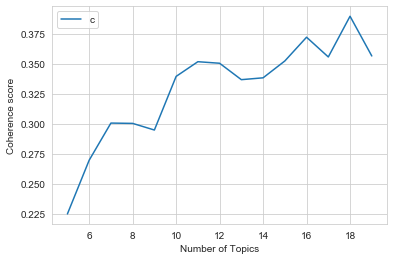

In [139]:
plt.plot(topics_range, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence scores"), loc='best')
plt.show()

In [254]:
lda_model = model_list[np.argmax(coherence_score)]

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.032*"protest" + 0.022*"prison" + 0.020*"year" + 0.016*"sentenc" + 0.015*"thousand" + 0.015*"jail" + 0.011*"releas" + 0.010*"get" + 0.010*"death" + 0.009*"onlin"


Topic: 1 
Words: 0.046*"russian" + 0.026*"russia" + 0.023*"iraq" + 0.022*"putin" + 0.019*"milit" + 0.017*"forc" + 0.014*"state" + 0.013*"strike" + 0.013*"say" + 0.013*"troop"


Topic: 2 
Words: 0.046*"korea" + 0.042*"north" + 0.042*"china" + 0.042*"south" + 0.035*"iran" + 0.029*"nuclear" + 0.022*"sea" + 0.020*"missil" + 0.017*"launch" + 0.016*"test"


Topic: 3 
Words: 0.042*"state" + 0.042*"islam" + 0.036*"right" + 0.034*"human" + 0.021*"muslim" + 0.017*"group" + 0.011*"indonesia" + 0.011*"central" + 0.011*"malaysia" + 0.010*"earthquak"


Topic: 4 
Words: 0.033*"philippin" + 0.032*"climat" + 0.030*"chang" + 0.016*"hong" + 0.016*"kong" + 0.014*"raid" + 0.012*"asylum" + 0.012*"australia" + 0.011*"polic" + 0.010*"world"


Topic: 5 
Words: 0.040*"saudi" + 0.023*"militari" + 0.022*"pakistan" + 0.020*"arabia" + 0

## 3. Topic chain over 2016
* Fit a LDA model for news titles of every month in 2016
* Measure the similarity between topics using Hellinger distance 
* Find long and short term topics in 2016

In [227]:
model_month = []
for m in range(1,13):
    corpus_by_month = [bow_corpus[i] for i in range(len(docs)) if news['year'][i]== 2016 and news['month'][i] == m]
    model_by_month = LdaMulticore(corpus_by_month, num_topics=7, id2word=dictionary)
    model_month.append(model_by_month)

In [252]:
from gensim.matutils import hellinger

thresh = 0.3
chain = np.full((11, 7), None)
metric = np.ones([11,7])
for m in range(1,12):
    for cur in range(7):
        for pre in range(7):
            dis = hellinger(model_month[m].get_topics()[cur], model_month[m-1].get_topics()[pre])
            if dis < min(thresh,metric[m-1][cur]):
                metric[m-1][cur] = dis
                chain[m-1][cur] = pre

In [253]:
chain

array([[None, 2, None, 1, None, None, None],
       [None, None, None, 2, None, None, None],
       [None, None, 3, None, None, None, None],
       [None, 2, None, None, None, None, None],
       [None, 1, None, 1, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, 0, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [5, 5, 5, 5, 5, 5, 5],
       [None, None, None, None, None, None, None]], dtype=object)

In [272]:
print('Long term topic:')
print(model_month[1].print_topics()[2])
print(model_month[2].print_topics()[3])
print(model_month[3].print_topics()[2])
print(model_month[4].print_topics()[1])

print("\n")
print('Major events in a short time:')
print(model_month[9].print_topics()[5])

Long term topic:
(2, '0.004*"china" + 0.003*"attack" + 0.002*"say" + 0.002*"india" + 0.002*"south" + 0.002*"abus" + 0.002*"north" + 0.002*"korea" + 0.002*"kill" + 0.002*"bomb"')
(3, '0.003*"kill" + 0.002*"say" + 0.002*"govern" + 0.002*"refuge" + 0.002*"syrian" + 0.002*"india" + 0.002*"new" + 0.002*"polic" + 0.001*"syria" + 0.001*"million"')
(2, '0.003*"world" + 0.003*"set" + 0.002*"korea" + 0.002*"protest" + 0.002*"kill" + 0.002*"plan" + 0.002*"north" + 0.002*"syria" + 0.002*"isi" + 0.002*"aleppo"')
(1, '0.003*"kill" + 0.002*"govern" + 0.002*"leader" + 0.002*"million" + 0.002*"say" + 0.002*"new" + 0.002*"child" + 0.002*"countri" + 0.001*"year" + 0.001*"presid"')


Major events in a short time:
(5, '0.005*"news" + 0.004*"bbc" + 0.002*"russian" + 0.002*"south" + 0.002*"plan" + 0.002*"attack" + 0.002*"mosul" + 0.002*"new" + 0.001*"india" + 0.001*"kill"')


## Reference:
[gensim: LDA](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-download-auto-examples-tutorials-run-lda-py)

[gensim: Distance Metrics](https://radimrehurek.com/gensim/auto_examples/tutorials/run_distance_metrics.html)

[Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

[Topic Modeling in Python](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

[Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
